In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/社群媒體探勘/HW/Project/code')  #切換該目錄
os.listdir()  #確認目錄內容

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['dataset', 'TaipeiSansTCBeta-Regular.ttf', '分析+預處理.ipynb']

In [2]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https: // drive.google.com / uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ & export=download

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 改style要在改font之前
# plt.style.use('seaborn')

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2022-05-13 05:16:09--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 173.194.215.138, 173.194.215.102, 173.194.215.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.215.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hm904okqahnbgfutd8gl6lehdo9ch3qp/1652418900000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2022-05-13 05:16:09--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hm904okqahnbgfutd8gl6lehdo9ch3qp/1652418900000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.250.97.132, 2607:f8b0:400c:c18::84
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|142.250.97

In [3]:
!pip install nltk == 3.4

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re
import jieba
import json
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from numpy.linalg import norm
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
#import pyLDAvis.gensim_models

In [5]:
# 移除警告語，視覺上比較乾淨
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
plt.rcParams['font.sans-serif'] = ['Noto Sans TC']  #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False  #使負號能夠顯示
plt.rcParams['font.sans-serif'] = ['SimHei']  #使中文能正常顯示

## 載入所有留言

In [7]:
#匯入資料
with open('./dataset/detail_articles.json', 'r', encoding='utf-8') as f:
    temp = json.load(f)
cols = ['article_id', 'article_title', 'author', 'board', 'date', 'content', 'all', 'boo', 'count', 'neutral', 'push']
rows = []


In [8]:
for data in temp:
    message_count = data['message_count']
    sum = data['message_count']['all']
    boo = data['message_count']['boo']
    count = data['message_count']['count']
    neutral = data['message_count']['neutral']
    push = data['message_count']['push']
    rows.append(
        [data['article_id'], data['article_title'], data['author'], data['board'], data['date'], data['content'], sum,
         boo, count, neutral, push])
f.close()

In [9]:
Meta = pd.DataFrame(rows, columns=cols)
Meta.head(3)

,article_id,article_title,author,board,date,content,all,boo,count,neutral,push
0,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,Tue May 10 17:28:45 2022,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果 ht...,6,1,3,1,4
1,M.1652174089.A.985,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,ricky525 (月滿江瀾),Gossiping,Tue May 10 17:14:46 2022,台灣人從最初的俄羅斯入侵 念及自身的一片悲觀 到現在普遍的正面反映 樂觀其成 但事實上 輿論...,14,2,-2,12,0
2,M.1652173205.A.917,[問卦] 普丁要全面進攻烏克蘭了？,plzza0cats (沙花叉クロヱ的狗),Gossiping,Tue May 10 17:00:02 2022,欸欸 我之前看關鍵時刻 來賓對寶傑說5/9日勝利日俄羅斯要全面進攻烏克蘭 請問現在基輔被打下...,10,0,5,5,5


In [10]:
Meta.shape

(3149, 11)

In [11]:
with open('./dataset/detail_articles.json', 'r', encoding='utf-8') as f:
    temp = json.load(f)
cols = ['article_id', 'article_title', 'author', 'board', 'date', 'content', 'message_count', 'push_content',
        'push_userid', 'push_tag']
rows = []
for data in temp:
    data_id = data['article_id']
    message_count = data['message_count']['all']
    messages = data['messages']
    for m in messages:
        rows.append([data_id, data['article_title'], data['author'], data['board'], data['date'], data['content'],
                     message_count, m['push_content'], m['push_userid'], m['push_tag']])
f.close()
Reviews = pd.DataFrame(rows, columns=cols)
Reviews.head(3)

,article_id,article_title,author,board,date,content,message_count,push_content,push_userid,push_tag
0,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,Tue May 10 17:28:45 2022,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果 ht...,6,類似 眼鏡蛇車 的存在意義！,vwpassat,噓
1,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,Tue May 10 17:28:45 2022,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果 ht...,6,"有道理,加拿大的神不能亡!!!",yoshiringo,推
2,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,Tue May 10 17:28:45 2022,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果 ht...,6,唉，中肯,kpier2,推


## 資料清理


In [12]:
Meta.head(5)

,article_id,article_title,author,board,date,content,all,boo,count,neutral,push
0,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,Tue May 10 17:28:45 2022,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果 ht...,6,1,3,1,4
1,M.1652174089.A.985,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,ricky525 (月滿江瀾),Gossiping,Tue May 10 17:14:46 2022,台灣人從最初的俄羅斯入侵 念及自身的一片悲觀 到現在普遍的正面反映 樂觀其成 但事實上 輿論...,14,2,-2,12,0
2,M.1652173205.A.917,[問卦] 普丁要全面進攻烏克蘭了？,plzza0cats (沙花叉クロヱ的狗),Gossiping,Tue May 10 17:00:02 2022,欸欸 我之前看關鍵時刻 來賓對寶傑說5/9日勝利日俄羅斯要全面進攻烏克蘭 請問現在基輔被打下...,10,0,5,5,5
3,M.1652172258.A.4B9,[新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,meiyouo (開洋葷),Gossiping,Tue May 10 16:44:15 2022,三立 狙神瓦力回加拿大曝對烏克蘭失望 本尊回應：我錯了 記者楊佩琪綜合報導 被稱為狙神的加拿...,94,6,38,44,44
4,M.1652171523.A.6C7,[問卦] 烏克蘭當年到底該不該放棄核武?,allenc38 (我現在只想被肛),Gossiping,Tue May 10 16:31:58 2022,緊握核武不放手 可能經濟被孤立 蘇聯遺毒官員有貪污紀錄 可能民主化緩慢 變成東歐的北韓 但黑...,39,1,8,29,9


In [13]:
Meta['content'] = Meta.content.apply(
    lambda x: re.sub('(媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', str(x)))
Meta['content'] = Meta.content.apply(lambda x: re.sub('(http|https)://.*', '', x))
Meta['content'] = Meta.content.apply(lambda x: re.sub('\n', ',', x))
Meta['content'] = Meta.content.apply(lambda x: re.sub('\n', ',', x))

In [14]:
Meta.head(5)

,article_id,article_title,author,board,date,content,all,boo,count,neutral,push
0,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,Tue May 10 17:28:45 2022,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果,6,1,3,1,4
1,M.1652174089.A.985,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,ricky525 (月滿江瀾),Gossiping,Tue May 10 17:14:46 2022,台灣人從最初的俄羅斯入侵 念及自身的一片悲觀 到現在普遍的正面反映 樂觀其成 但事實上 輿論...,14,2,-2,12,0
2,M.1652173205.A.917,[問卦] 普丁要全面進攻烏克蘭了？,plzza0cats (沙花叉クロヱ的狗),Gossiping,Tue May 10 17:00:02 2022,欸欸 我之前看關鍵時刻 來賓對寶傑說5/9日勝利日俄羅斯要全面進攻烏克蘭 請問現在基輔被打下...,10,0,5,5,5
3,M.1652172258.A.4B9,[新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,meiyouo (開洋葷),Gossiping,Tue May 10 16:44:15 2022,三立 狙神瓦力回加拿大曝對烏克蘭失望 本尊回應：我錯了 記者楊佩琪綜合報導 被稱為狙神的加拿...,94,6,38,44,44
4,M.1652171523.A.6C7,[問卦] 烏克蘭當年到底該不該放棄核武?,allenc38 (我現在只想被肛),Gossiping,Tue May 10 16:31:58 2022,緊握核武不放手 可能經濟被孤立 蘇聯遺毒官員有貪污紀錄 可能民主化緩慢 變成東歐的北韓 但黑...,39,1,8,29,9


### jeiba


In [15]:
jieba.set_dictionary('./dataset/jieba/dict.txt.big')
with open('./dataset/jieba/stop_words.txt', encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [16]:
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1]  # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [17]:
data = Meta.copy()
data['word'] = data.content.apply(getToken)

Building prefix dict from /content/drive/MyDrive/社群媒體探勘/HW/Project/code/dataset/jieba/dict.txt.big ...
Loading model from cache /tmp/jieba.ucab88f751bae4b383c2b0fd5a94c6943.cache
Loading model cost 3.391 seconds.
Prefix dict has been built successfully.


In [18]:
data.head(3)

,article_id,article_title,author,board,date,content,all,boo,count,neutral,push,word
0,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,Tue May 10 17:28:45 2022,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果,6,1,3,1,4,"[其實, EY, 瓦力, 94, 烏克蘭, 主牌, 長距離, 狙擊, 只要, 牽制, 敵人,..."
1,M.1652174089.A.985,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,ricky525 (月滿江瀾),Gossiping,Tue May 10 17:14:46 2022,台灣人從最初的俄羅斯入侵 念及自身的一片悲觀 到現在普遍的正面反映 樂觀其成 但事實上 輿論...,14,2,-2,12,0,"[台灣, 最初, 俄羅斯, 入侵, 念及, 自身, 一片, 悲觀, 現在, 普遍, 正面, ..."
2,M.1652173205.A.917,[問卦] 普丁要全面進攻烏克蘭了？,plzza0cats (沙花叉クロヱ的狗),Gossiping,Tue May 10 17:00:02 2022,欸欸 我之前看關鍵時刻 來賓對寶傑說5/9日勝利日俄羅斯要全面進攻烏克蘭 請問現在基輔被打下...,10,0,5,5,5,"[之前, 關鍵時刻, 來賓, 對寶傑, 勝利, 俄羅斯, 全面, 進攻, 烏克蘭, 請問, ..."


## LDA

In [19]:
token_data = data['word'].tolist()

In [20]:
id2word = corpora.Dictionary(token_data)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(37092 unique tokens: ['94', 'EY', '主牌', '其實', '只要']...)


In [21]:
corpus = [id2word.doc2bow(text) for text in token_data]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


In [22]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus,  # 文檔語料庫
    id2word=id2word,  # 詞彙字典
    num_topics=8,  # 生成幾個主題數
    random_state=1205,  # 亂數
    iterations=5000,  # 每個文章訓練的次數，可以設定高一點讓模型收斂
    passes=5,  # 模型訓練次數
)

In [23]:
# 每個主題重要的前25個關鍵字
topics = ldamodel.print_topics(num_words=25)
for topic in topics:
    print(topic)
    print("")

(0, '0.020*"烏克蘭" + 0.019*"俄羅斯" + 0.012*"中國" + 0.006*"戰爭" + 0.006*"美國" + 0.005*"現在" + 0.005*"國家" + 0.004*"可以" + 0.004*"俄國" + 0.004*"台灣" + 0.004*"日本" + 0.004*"自己" + 0.003*"可能" + 0.003*"不會" + 0.003*"就是" + 0.003*"普丁" + 0.003*"如果" + 0.003*"還是" + 0.003*"媒體" + 0.002*"支持" + 0.002*"俄軍" + 0.002*"但是" + 0.002*"歐洲" + 0.002*"報導" + 0.002*"什麼"')

(1, '0.008*"烏克蘭" + 0.007*"難民" + 0.005*"李根" + 0.004*"大尉" + 0.004*"波蘭" + 0.003*"俄羅斯" + 0.003*"媒體" + 0.003*"報導" + 0.003*"戰爭" + 0.003*"記者" + 0.003*"Russia" + 0.003*"連結" + 0.003*"南韓" + 0.002*"said" + 0.002*"邊境" + 0.002*"外交部" + 0.002*"國家" + 0.002*"歐洲" + 0.002*"新聞" + 0.002*"芬蘭" + 0.002*"因為" + 0.002*"已經" + 0.002*"物資" + 0.002*"Putin" + 0.002*"國際"')

(2, '0.025*"烏克蘭" + 0.025*"台灣" + 0.013*"俄羅斯" + 0.012*"中國" + 0.008*"戰爭" + 0.007*"就是" + 0.007*"美國" + 0.006*"國家" + 0.005*"現在" + 0.005*"什麼" + 0.005*"自己" + 0.005*"中共" + 0.004*"可以" + 0.004*"如果" + 0.004*"所以" + 0.004*"不是" + 0.004*"知道" + 0.004*"這樣" + 0.003*"因為" + 0.003*"還是" + 0.003*"俄國" + 0.003*"應該" + 0.003*"一樣" + 0.003*"武器" + 0.003

In [24]:
PMI_model_lda = CoherenceModel(model=ldamodel, texts=token_data, coherence='c_uci')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

這個主題的 PMI score:  -1.0809128555017988


In [25]:
perplexity = ldamodel.log_perplexity(corpus)
print('這個主題的 Perplexity Score: ', perplexity)

這個主題的 Perplexity Score:  -8.860154119494016


In [26]:
#topic_num_list = np.arange(2, 12, 2)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus=corpus,
        num_topics=topic_num,
        id2word=id2word,
        random_state=1500,
        passes=5,
        iterations=2000
    )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)

    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity": temp_skleran})

NameError: ignored

In [ ]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

In [ ]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

##### 取八個

In [27]:
# 取得每筆發文的主題分佈
topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0)

# 把每筆發文的主題分佈存成list
probabilities = [[entry[1] for entry in doc] for doc in topics_doc]
print(probabilities[0:7])

# 找出probabilities最大的主題 存入 doc_list
doc_list = [np.argmax(t) for t in probabilities]

[[0.009625412, 0.009696833, 0.93257153, 0.009618523, 0.009619781, 0.009618844, 0.009622997, 0.009626085], [0.7019493, 0.0014906288, 0.001491399, 0.0014908537, 0.0014912472, 0.001489384, 0.0014915518, 0.28910565], [0.0050123166, 0.0050035752, 0.0050112265, 0.9649469, 0.005007855, 0.0050049066, 0.005005268, 0.0050079455], [0.00044715617, 0.27791202, 0.13908888, 0.00044711976, 0.00044722404, 0.00044667677, 0.00044684336, 0.58076406], [0.25555164, 0.0033802793, 0.19250037, 0.0033827364, 0.0033858921, 0.0033836574, 0.18716267, 0.35125276], [0.0021974146, 0.0021981315, 0.73260576, 0.0021971774, 0.0021954596, 0.085849985, 0.002196059, 0.17056002], [0.2943469, 0.0056863176, 0.6715269, 0.0056871725, 0.005686705, 0.0056845043, 0.0056944285, 0.0056870654]]


In [28]:
# 將結果放進 DataFrame裏
data['topic'] = doc_list

In [29]:
data[["article_id", "article_title", "topic"]].head(200)

,article_id,article_title,topic
0,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,2
1,M.1652174089.A.985,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,0
2,M.1652173205.A.917,[問卦] 普丁要全面進攻烏克蘭了？,3
3,M.1652172258.A.4B9,[新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,7
4,M.1652171523.A.6C7,[問卦] 烏克蘭當年到底該不該放棄核武?,7
...,...,...,...
195,M.1651276054.A.369,[新聞] 若米格-29戰機援烏 波蘭將協助守衛斯洛伐,7
196,M.1651254639.A.44A,[新聞] 科幻電影逐漸成真，俄烏戰爭使各國對 AI,7
197,M.1651245754.A.EA0,[新聞] 蕭茲首訪日本 與岸田反對中俄以武力改變,7
198,M.1651244828.A.59C,[問卦] 烏索普跟騙人布 那個翻譯比較好？,2


### 資料內容探索

In [30]:
# topic0
data[(data["topic"] == 0) & (data["article_title"])][["article_id", "article_title", "topic"]].sample(n=10)

,article_id,article_title,topic
671,M.1649868091.A.24F,[問卦] 日本要派自衛隊運輸機前往烏克蘭？,0
1738,M.1648276006.A.435,[問卦] 烏克蘭有能力直接打到俄國本土嗎?,0
725,M.1649778550.A.B5B,Re: [新聞] 俄羅斯入侵烏克蘭：普京臉書粉絲團的神秘,0
2224,M.1647844433.A.FFB,[問卦] 烏克蘭健身公園,0
1239,M.1648966181.A.077,[問卦] 板上支持俄羅斯的素質？,0
999,M.1649242435.A.C7F,[新聞] 德國警方搗毀俄羅斯大型暗網Hydra,0
708,M.1649819232.A.056,Re: [新聞] 烏克蘭女性被俄軍「集體關地下室」25天！,0
1689,M.1648345438.A.25D,[問卦] 為什麼蘇聯可以打衛國戰爭 烏克蘭不行？,0
1365,M.1648730192.A.657,[問卦] 俄羅斯人的素質484比美國人高？？,0
2506,M.1647575148.A.459,[問卦] 俄烏戰爭大家看到了什麼？,0


In [31]:
# topic1
data[(data["topic"] == 1) & (data["article_title"])][["article_id", "article_title", "topic"]].sample(n=10)

,article_id,article_title,topic
2425,M.1647661487.A.181,Re: [新聞] 美傭兵到烏克蘭支援 被派前線作戰秒落,1
2947,M.1647251667.A.98F,Re: [新聞] 俄烏戰爭 我國電費是否調漲？ 王美花：4,1
685,M.1649846092.A.3F3,Re: [新聞] 假的！網傳芬蘭女總理怒嗆俄？綠委、486,1
1775,M.1648255913.A.C5A,[問卦] 俄羅斯高官都被死亡筆記了嗎？,1
2695,M.1647422717.A.BC9,[問卦] 假如俄羅斯不賣引擎給中國,1
3030,M.1647178185.A.953,Re: [問卦] 俄羅斯會組成同盟國還是軸心國?,1
2886,M.1647277635.A.E76,[問卦] 如果烏軍換成國軍能撐幾天?,1
2418,M.1647665052.A.14E,[問卦] 俄羅斯人買東西很霸氣?,1
978,M.1649284536.A.E20,[新聞] 李根大尉最新動態曝！參與烏克蘭「機密,1
3046,M.1647175647.A.BD0,[新聞] 抵制俄羅斯再出招，歐洲禁止俄人員繼續,1


In [32]:
# topic2
data[(data["topic"] == 2) & (data["article_title"])][["article_id", "article_title", "topic"]].sample(n=10)

,article_id,article_title,topic
726,M.1649777962.A.895,[問卦] 烏俄戰爭電影會被整麼詮釋？,2
278,M.1650953787.A.E98,[問卦] 戰爭結束後，台烏關係會加深嗎？,2
467,M.1650366274.A.822,[問卦] 俄烏戰爭後西方會協助烏克蘭重建嗎?,2
1871,M.1648166714.A.847,Re: [問卦]烏克蘭都能擋俄1個月 為何說台灣撐不過？,2
1504,M.1648481140.A.2C9,Re: [問卦] 杜奕瑾:烏俄戰爭駐批踢踢內應的也沒閒著,2
1701,M.1648317497.A.D47,Re: [新聞] 華碩沒退出俄羅斯？ 耶魯大學1驚人名單曝,2
1253,M.1648947112.A.38D,[問卦] 為什麼俄羅斯不用中國的衛星?,2
1063,M.1649162251.A.418,[問卦]不開玩笑，一人說一個捐9億給烏克蘭的好處,2
2192,M.1647872157.A.52D,Re: [新聞] 俄軍下通牒籲馬立波繳械投降 烏克蘭副總,2
1724,M.1648290679.A.C1E,[問卦] 跟俄軍說魯夫吃人人果實會怎樣,2


In [33]:
# 轉換artDate為 Python 日期格式
from datetime import datetime

data['date'] = pd.to_datetime(data['date'], format="%c").dt.strftime('%Y-%m-%d')

In [34]:
date_topic = pd.DataFrame({
    'count': data.groupby(['date', 'topic']).size()
})

date_topic = date_topic.reset_index()
date_topic

,date,topic,count
0,2022-03-13,0,27
1,2022-03-13,1,8
2,2022-03-13,2,37
3,2022-03-13,3,12
4,2022-03-13,4,5
...,...,...,...
403,2022-05-09,7,7
404,2022-05-10,0,2
405,2022-05-10,2,3
406,2022-05-10,3,1


In [35]:
date_df = date_topic.pivot_table(index='date', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['date', 'topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7']
date_df = date_df.set_index('date')
date_df.head(5)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
date,,,,,,,,
2022-03-13,27.0,8.0,37.0,12.0,5.0,3.0,7.0,33.0
2022-03-14,17.0,5.0,41.0,14.0,8.0,6.0,12.0,18.0
2022-03-15,28.0,6.0,32.0,9.0,10.0,9.0,8.0,26.0
2022-03-16,18.0,4.0,35.0,11.0,9.0,4.0,9.0,23.0
2022-03-17,25.0,9.0,21.0,7.0,17.0,7.0,8.0,22.0


In [36]:
ratio_df = date_df.copy()
ratio_df['sum'] = ratio_df.topic0 + ratio_df.topic1 + ratio_df.topic2 + ratio_df.topic3

for i in range(0, 8):
    ratio_df['topic' + str(i)] = ratio_df['topic' + str(i)] / ratio_df['sum']

ratio_df.head(5)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,sum
date,,,,,,,,,
2022-03-13,0.321429,0.095238,0.440476,0.142857,0.059524,0.035714,0.083333,0.392857,84.0
2022-03-14,0.220779,0.064935,0.532468,0.181818,0.103896,0.077922,0.155844,0.233766,77.0
2022-03-15,0.373333,0.080000,0.426667,0.120000,0.133333,0.120000,0.106667,0.346667,75.0
2022-03-16,0.264706,0.058824,0.514706,0.161765,0.132353,0.058824,0.132353,0.338235,68.0
2022-03-17,0.403226,0.145161,0.338710,0.112903,0.274194,0.112903,0.129032,0.354839,62.0


In [37]:
data_topic1 = data[data['topic'] == 0]  #
data_topic2 = data[data['topic'] == 1]  #
data_topic3 = data[data['topic'] == 2]  #
data_topic4 = data[data['topic'] == 3]  #
data_topic5 = data[data['topic'] == 4]  #
data_topic6 = data[data['topic'] == 5]  #
data_topic7 = data[data['topic'] == 6]  #
data_topic8 = data[data['topic'] == 7]  #

In [38]:
bigramfdist1 = FreqDist()
bigramfdist2 = FreqDist()
bigramfdist3 = FreqDist()
bigramfdist4 = FreqDist()
bigramfdist5 = FreqDist()
bigramfdist6 = FreqDist()
bigramfdist7 = FreqDist()
bigramfdist8 = FreqDist()


def bigram_getToken_dict(row, dist, n=2):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1]
    dist.update(ngrams(seg_list, n))
    seg_list2 = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [39]:
data_topic1["word"] = data_topic1.content.apply(lambda x: bigram_getToken_dict(row=x, n=2, dist=bigramfdist1))
data_topic2["word"] = data_topic2.content.apply(lambda x: bigram_getToken_dict(row=x, n=2, dist=bigramfdist2))
data_topic3["word"] = data_topic3.content.apply(lambda x: bigram_getToken_dict(row=x, n=2, dist=bigramfdist3))
data_topic4["word"] = data_topic4.content.apply(lambda x: bigram_getToken_dict(row=x, n=2, dist=bigramfdist4))
data_topic5["word"] = data_topic5.content.apply(lambda x: bigram_getToken_dict(row=x, n=2, dist=bigramfdist5))
data_topic6["word"] = data_topic6.content.apply(lambda x: bigram_getToken_dict(row=x, n=2, dist=bigramfdist6))
data_topic7["word"] = data_topic7.content.apply(lambda x: bigram_getToken_dict(row=x, n=2, dist=bigramfdist7))
data_topic8["word"] = data_topic8.content.apply(lambda x: bigram_getToken_dict(row=x, n=2, dist=bigramfdist8))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [40]:
#建立bigram和count的dictionary
#這裡取最多的前30項
d1 = {k: v for k, v in bigramfdist1.most_common(30)}
d2 = {k: v for k, v in bigramfdist2.most_common(30)}
d3 = {k: v for k, v in bigramfdist3.most_common(30)}
d4 = {k: v for k, v in bigramfdist4.most_common(30)}
d5 = {k: v for k, v in bigramfdist5.most_common(30)}
d6 = {k: v for k, v in bigramfdist6.most_common(30)}
d7 = {k: v for k, v in bigramfdist7.most_common(30)}
d8 = {k: v for k, v in bigramfdist8.most_common(30)}

In [41]:
G1 = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d1][0].items():
    G1.add_edge(k[0], k[1], weight=v)

# 取得edge權重
weights1 = [w[2]['weight'] * 0.03 for w in G1.edges(data=True)]

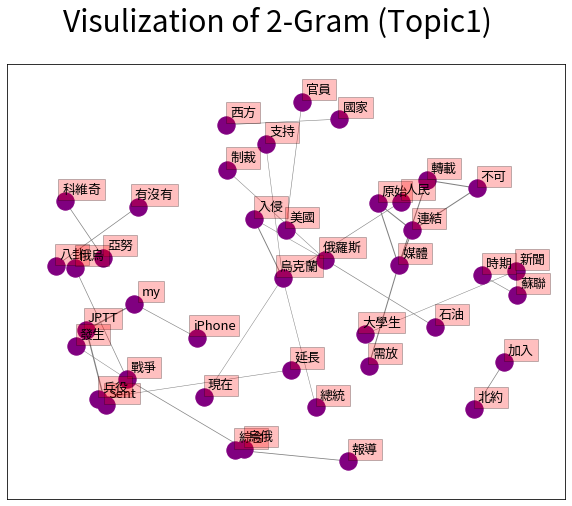

In [42]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G1, k=2)

# networks
nx.draw_networkx(G1, pos,
                 font_size=16,
                 width=weights1,
                 edge_color='grey',
                 node_color='purple',
                 with_labels=False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0] + .07, value[1] + .045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
fig.suptitle('Visulization of 2-Gram (Topic1)', fontsize=30)
plt.show()

In [43]:
G2 = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d2][0].items():
    G2.add_edge(k[0], k[1], weight=v)

# 取得edge權重
weights2 = [w[2]['weight'] * 0.03 for w in G2.edges(data=True)]

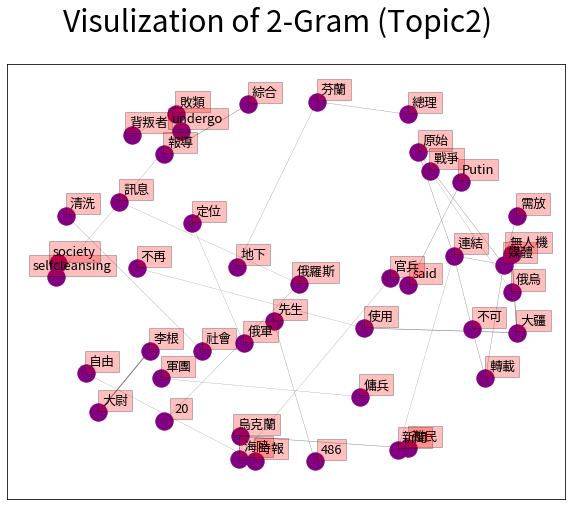

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G2, k=2)

# networks
nx.draw_networkx(G2, pos,
                 font_size=16,
                 width=weights2,
                 edge_color='grey',
                 node_color='purple',
                 with_labels=False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0] + .07, value[1] + .045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
fig.suptitle('Visulization of 2-Gram (Topic2)', fontsize=30)
plt.show()

In [45]:
G3 = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d3][0].items():
    G3.add_edge(k[0], k[1], weight=v)

# 取得edge權重
weights3 = [w[2]['weight'] * 0.03 for w in G3.edges(data=True)]

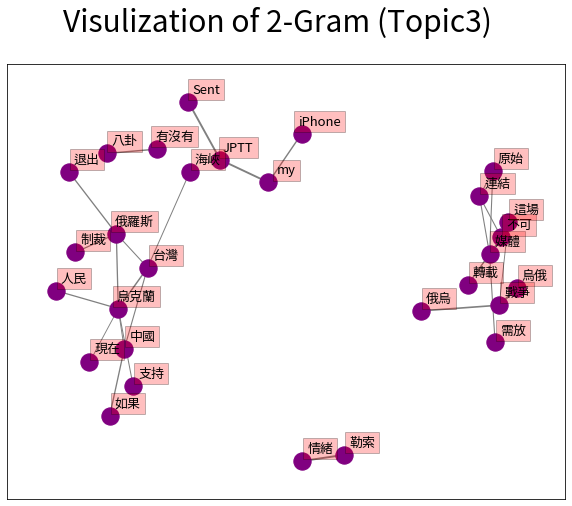

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G3, k=2)

# networks
nx.draw_networkx(G3, pos,
                 font_size=16,
                 width=weights3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels=False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0] + .07, value[1] + .045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
fig.suptitle('Visulization of 2-Gram (Topic3)', fontsize=30)
plt.show()

In [47]:
G4 = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d4][0].items():
    G4.add_edge(k[0], k[1], weight=v)

# 取得edge權重
weights4 = [w[2]['weight'] * 0.03 for w in G4.edges(data=True)]

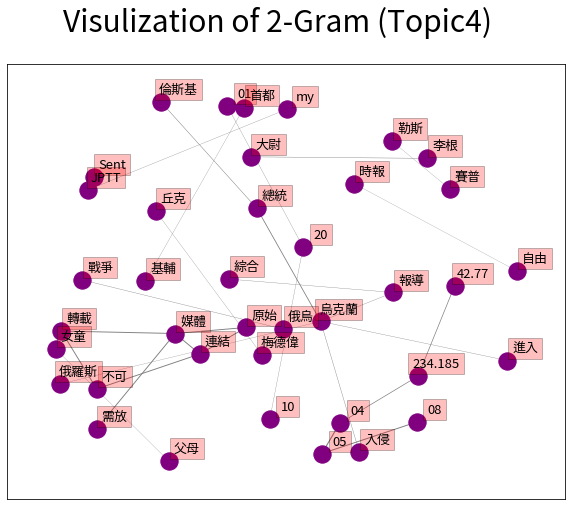

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G4, k=2)

# networks
nx.draw_networkx(G4, pos,
                 font_size=16,
                 width=weights4,
                 edge_color='grey',
                 node_color='purple',
                 with_labels=False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0] + .07, value[1] + .045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
fig.suptitle('Visulization of 2-Gram (Topic4)', fontsize=30)
plt.show()

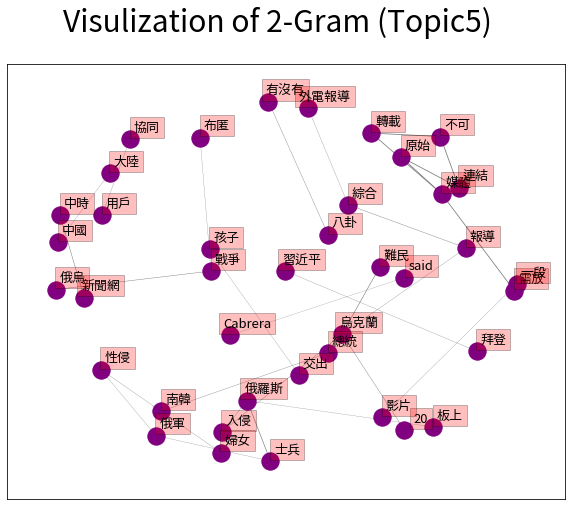

In [49]:
G5 = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d5][0].items():
    G5.add_edge(k[0], k[1], weight=v)

# 取得edge權重
weights5 = [w[2]['weight'] * 0.03 for w in G5.edges(data=True)]
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G5, k=2)

# networks
nx.draw_networkx(G5, pos,
                 font_size=16,
                 width=weights5,
                 edge_color='grey',
                 node_color='purple',
                 with_labels=False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0] + .07, value[1] + .045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
fig.suptitle('Visulization of 2-Gram (Topic5)', fontsize=30)
plt.show()

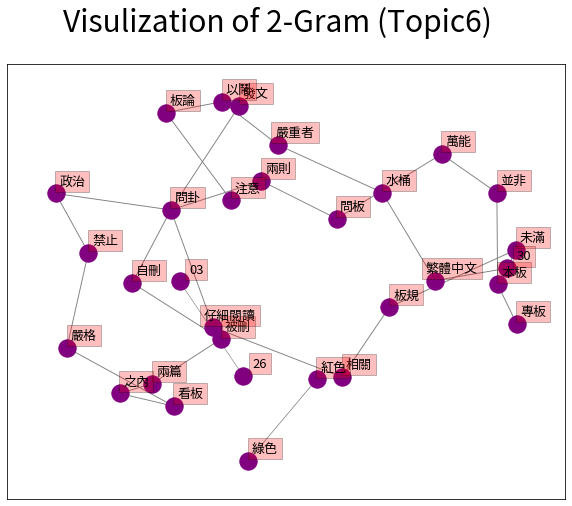

In [50]:
G6 = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d6][0].items():
    G6.add_edge(k[0], k[1], weight=v)

# 取得edge權重
weights6 = [w[2]['weight'] * 0.03 for w in G6.edges(data=True)]
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G6, k=2)

# networks
nx.draw_networkx(G6, pos,
                 font_size=16,
                 width=weights6,
                 edge_color='grey',
                 node_color='purple',
                 with_labels=False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0] + .07, value[1] + .045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
fig.suptitle('Visulization of 2-Gram (Topic6)', fontsize=30)
plt.show()

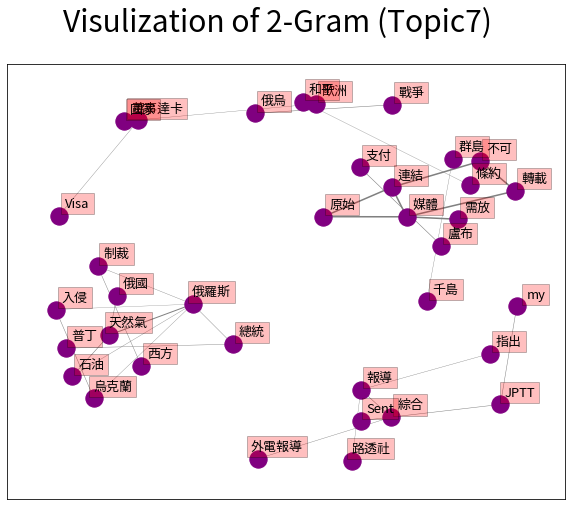

In [51]:
G7 = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d7][0].items():
    G7.add_edge(k[0], k[1], weight=v)

# 取得edge權重
weights7 = [w[2]['weight'] * 0.03 for w in G7.edges(data=True)]
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G7, k=2)

# networks
nx.draw_networkx(G7, pos,
                 font_size=16,
                 width=weights7,
                 edge_color='grey',
                 node_color='purple',
                 with_labels=False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0] + .07, value[1] + .045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
fig.suptitle('Visulization of 2-Gram (Topic7)', fontsize=30)
plt.show()

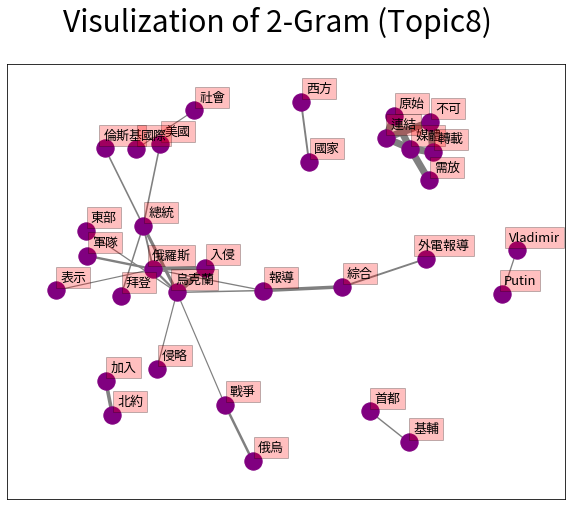

In [52]:
G8 = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d8][0].items():
    G8.add_edge(k[0], k[1], weight=v)

# 取得edge權重
weights8 = [w[2]['weight'] * 0.03 for w in G8.edges(data=True)]
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G8, k=2)

# networks
nx.draw_networkx(G8, pos,
                 font_size=16,
                 width=weights8,
                 edge_color='grey',
                 node_color='purple',
                 with_labels=False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0] + .07, value[1] + .045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
fig.suptitle('Visulization of 2-Gram (Topic8)', fontsize=30)
plt.show()

## 社群網路圖


In [53]:
data.head(5)

,article_id,article_title,author,board,date,content,all,boo,count,neutral,push,word,topic
0,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,2022-05-10,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果,6,1,3,1,4,"[其實, EY, 瓦力, 94, 烏克蘭, 主牌, 長距離, 狙擊, 只要, 牽制, 敵人,...",2
1,M.1652174089.A.985,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,ricky525 (月滿江瀾),Gossiping,2022-05-10,台灣人從最初的俄羅斯入侵 念及自身的一片悲觀 到現在普遍的正面反映 樂觀其成 但事實上 輿論...,14,2,-2,12,0,"[台灣, 最初, 俄羅斯, 入侵, 念及, 自身, 一片, 悲觀, 現在, 普遍, 正面, ...",0
2,M.1652173205.A.917,[問卦] 普丁要全面進攻烏克蘭了？,plzza0cats (沙花叉クロヱ的狗),Gossiping,2022-05-10,欸欸 我之前看關鍵時刻 來賓對寶傑說5/9日勝利日俄羅斯要全面進攻烏克蘭 請問現在基輔被打下...,10,0,5,5,5,"[之前, 關鍵時刻, 來賓, 對寶傑, 勝利, 俄羅斯, 全面, 進攻, 烏克蘭, 請問, ...",3
3,M.1652172258.A.4B9,[新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,meiyouo (開洋葷),Gossiping,2022-05-10,三立 狙神瓦力回加拿大曝對烏克蘭失望 本尊回應：我錯了 記者楊佩琪綜合報導 被稱為狙神的加拿...,94,6,38,44,44,"[三立, 狙神, 瓦力, 加拿大, 曝對, 烏克蘭, 失望, 本尊, 回應, 我錯, 記者,...",7
4,M.1652171523.A.6C7,[問卦] 烏克蘭當年到底該不該放棄核武?,allenc38 (我現在只想被肛),Gossiping,2022-05-10,緊握核武不放手 可能經濟被孤立 蘇聯遺毒官員有貪污紀錄 可能民主化緩慢 變成東歐的北韓 但黑...,39,1,8,29,9,"[緊握, 核武, 放手, 可能, 經濟, 孤立, 蘇聯, 遺毒, 官員, 貪污, 紀錄, 可...",7


In [54]:
Reviews.head(5)

,article_id,article_title,author,board,date,content,message_count,push_content,push_userid,push_tag
0,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,Tue May 10 17:28:45 2022,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果 ht...,6,類似 眼鏡蛇車 的存在意義！,vwpassat,噓
1,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,Tue May 10 17:28:45 2022,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果 ht...,6,"有道理,加拿大的神不能亡!!!",yoshiringo,推
2,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,Tue May 10 17:28:45 2022,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果 ht...,6,唉，中肯,kpier2,推
3,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,Tue May 10 17:28:45 2022,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果 ht...,6,存在艦隊,GodOfGods,推
4,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,Tue May 10 17:28:45 2022,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果 ht...,6,有道理，有精神象徵在後面幫忙提振士,arcysaint,推


In [55]:
# 把reviews中 cmtPoster(回覆者), cmtStatus(推噓), cmtContent(留言) 合併到 data的資料表
posts_Reviews = Reviews.loc[:, ["article_id", "push_content", "push_userid", "push_tag"]]
posts_Reviews = pd.merge(data, posts_Reviews, how="right", on="article_id")
posts_Reviews = posts_Reviews[posts_Reviews["all"] > 0]

In [56]:
posts_Reviews.head(7)

,article_id,article_title,author,board,date,content,all,boo,count,neutral,push,word,topic,push_content,push_userid,push_tag
0,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,2022-05-10,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果,6,1,3,1,4,"[其實, EY, 瓦力, 94, 烏克蘭, 主牌, 長距離, 狙擊, 只要, 牽制, 敵人,...",2,類似 眼鏡蛇車 的存在意義！,vwpassat,噓
1,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,2022-05-10,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果,6,1,3,1,4,"[其實, EY, 瓦力, 94, 烏克蘭, 主牌, 長距離, 狙擊, 只要, 牽制, 敵人,...",2,"有道理,加拿大的神不能亡!!!",yoshiringo,推
2,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,2022-05-10,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果,6,1,3,1,4,"[其實, EY, 瓦力, 94, 烏克蘭, 主牌, 長距離, 狙擊, 只要, 牽制, 敵人,...",2,唉，中肯,kpier2,推
3,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,2022-05-10,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果,6,1,3,1,4,"[其實, EY, 瓦力, 94, 烏克蘭, 主牌, 長距離, 狙擊, 只要, 牽制, 敵人,...",2,存在艦隊,GodOfGods,推
4,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,2022-05-10,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果,6,1,3,1,4,"[其實, EY, 瓦力, 94, 烏克蘭, 主牌, 長距離, 狙擊, 只要, 牽制, 敵人,...",2,有道理，有精神象徵在後面幫忙提振士,arcysaint,推
5,M.1652174927.A.0E8,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,gk1329 (),Gossiping,2022-05-10,其實不EY啊 瓦力去94 烏克蘭的神主牌 超長距離狙擊 只要有他在 就有牽制敵人的效果,6,1,3,1,4,"[其實, EY, 瓦力, 94, 烏克蘭, 主牌, 長距離, 狙擊, 只要, 牽制, 敵人,...",2,氣就好,arcysaint,→
6,M.1652174089.A.985,Re: [新聞] 「狙神」瓦力回加拿大！曝對烏克蘭失望,ricky525 (月滿江瀾),Gossiping,2022-05-10,台灣人從最初的俄羅斯入侵 念及自身的一片悲觀 到現在普遍的正面反映 樂觀其成 但事實上 輿論...,14,2,-2,12,0,"[台灣, 最初, 俄羅斯, 入侵, 念及, 自身, 一片, 悲觀, 現在, 普遍, 正面, ...",0,世界都在幫烏克蘭 但是平民持續死傷,iam0718,→


In [57]:
link = posts_Reviews.loc[:, ["push_userid", "author", "article_id"]]
link.head(5)

,push_userid,author,article_id
0,vwpassat,gk1329 (),M.1652174927.A.0E8
1,yoshiringo,gk1329 (),M.1652174927.A.0E8
2,kpier2,gk1329 (),M.1652174927.A.0E8
3,GodOfGods,gk1329 (),M.1652174927.A.0E8
4,arcysaint,gk1329 (),M.1652174927.A.0E8


In [58]:
len(link)

176983

In [59]:
# Create network plot
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0, 100):
    G.add_edge(link["push_userid"][i], link["author"][i])

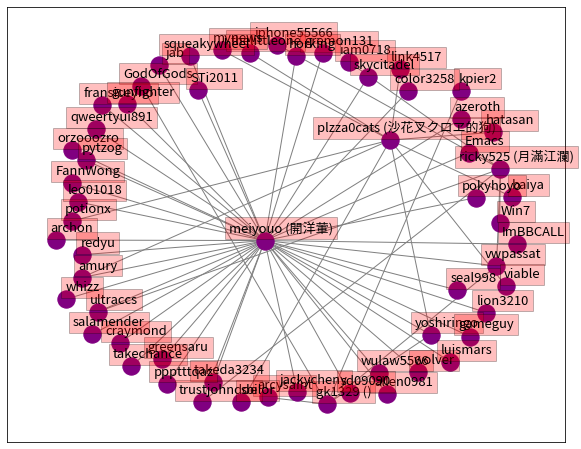

In [60]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 #                  width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels=False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0] + .07, value[1] + .045  #調整label的位置(右上)
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)

plt.show()

Text(0, 0.5, 'count')

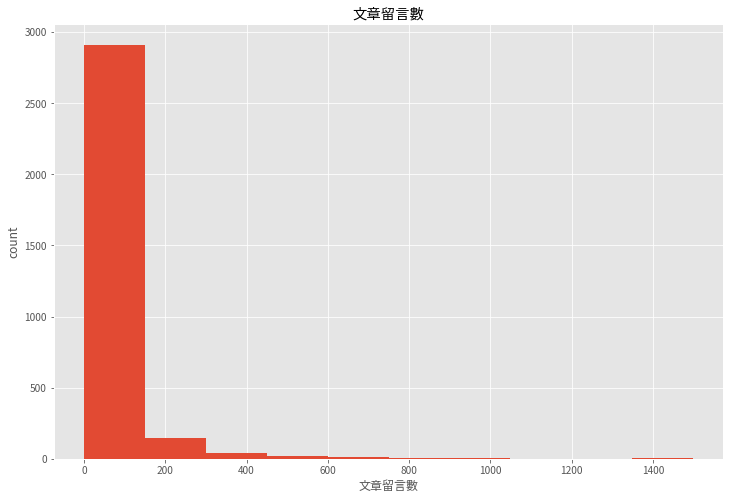

In [61]:
plt.figure(figsize=(12, 8))  # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")  # 使用ggplot主題樣式
plt.rcParams['font.sans-serif'] = ['SimHei']  #使中文能正常顯示
plt.hist(data["all"])

plt.title('文章留言數')
plt.xlabel('文章留言數')
plt.ylabel('count')

## 資料篩選


In [62]:
# 帳號發文篇數
pd.DataFrame(data.groupby("author").size(), columns=['count']).reset_index().sort_values(by="count", ascending=False)

,author,count
343,ai770116 (東方的神秘力量),60
1185,teeheehee (軟尾拋拋翔(′・ω・`)),34
1321,zalora (lara),31
1,A6 (短ID真好),27
425,ben28 (ben),26
...,...,...
573,fenix220 (菲),1
575,ff760725 (這肉燥飯有台灣價值),1
576,ffreakk (),1
577,fifa186 (落葉),1


In [63]:
# 檢視人數
print("發文者數量總共:", len(set(posts_Reviews["author"])))
print("回覆者數量總共:", len(set(posts_Reviews["push_userid"])))

發文者數量總共: 1332
回覆者數量總共: 19154


In [64]:
# 用set()得到不重複的集合
s = set(list(posts_Reviews["author"]) + list(posts_Reviews["push_userid"]))

In [65]:
allPoster = pd.DataFrame(list(s), columns=["user"])

In [66]:
allPoster["type"] = allPoster["user"].apply(lambda x: "poster" if x in list(data["author"]) else "replayer")

In [67]:
allPoster.head(2)

,user,type
0,dioradio (HIRO),poster
1,MYCDBABY ( justice ),poster


In [68]:
#時機點

posts_Reviews_alldate = (posts_Reviews.query('all>300').groupby(['push_userid', 'article_id'], as_index=False).size())

In [69]:
# 篩選有人在同一篇文章重複回覆大於5次
posts_Reviews_alldate = posts_Reviews_alldate.query('size>5')
posts_Reviews_alldate.head(3)

,push_userid,article_id,size
8,A80211ab,M.1648252720.A.495,12
26,ABiao0220,M.1648945395.A.C13,8
30,AFISH111,M.1649077952.A.0C9,8


In [70]:
# 因為需要push_userid所以merge link，之後使用drop_duplicates去除重複資料
link_all = pd.merge(posts_Reviews_alldate, link, on=["push_userid", "article_id"], how="left").drop_duplicates()
link_all.reset_index(inplace=True, drop=True)  #重設index
link_all.head(3)

,push_userid,article_id,size,author
0,A80211ab,M.1648252720.A.495,12,abramtw (世界原來是如此耀眼啊)
1,ABiao0220,M.1648945395.A.C13,8,huang19898 (huang19898)
2,AFISH111,M.1649077952.A.0C9,8,beaver (海狸王)


In [71]:
# Create network plot
# nx.Graph()為無向圖 ; nx.DiGraph()為有向圖
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0, len(link_all)):
    G.add_edge(link_all["push_userid"][i], link_all["author"][i])

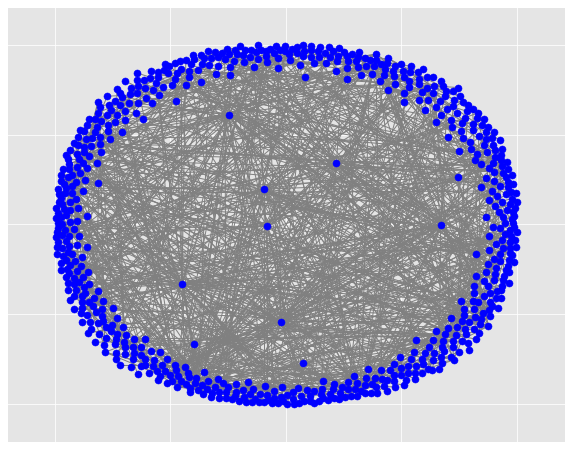

In [72]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color="blue",
                 with_labels=False,
                 ax=ax)

plt.show()

In [73]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"] == node]["type"].item() == "replayer":
        color_map.append('blue')
    else:
        color_map.append('red')

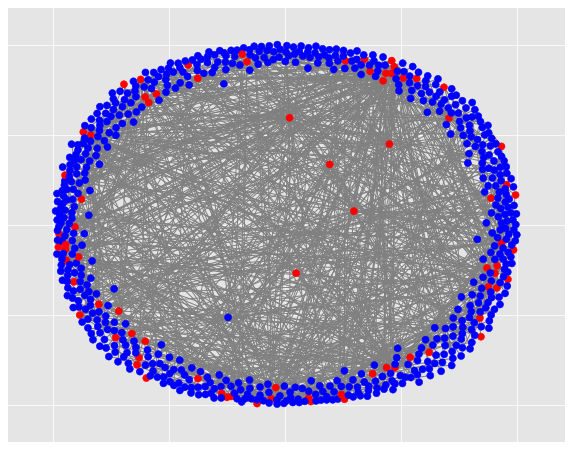

In [74]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels=False,
                 ax=ax)

plt.show()

In [75]:
# 刪除degree<1的點
to_be_removed = [x for x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [76]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
if allPoster[allPoster["user"] == node]["type"].item() == "replayer":
    color_map.append('blue')
else:
    color_map.append('red')

In [77]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val > 5]
degrees

['abramtw (世界原來是如此耀眼啊)',
 'huang19898 (huang19898)',
 'beaver (海狸王)',
 'leocean9816 (阿光)',
 'sandemo (一切都是剛剛開始)',
 'brokenback3 (3)',
 'around14358 (awq)',
 'biglarge (大大)',
 'Oisiossos (LV.1初心者)',
 'bluwind1 (藍天的風)',
 'BaRanKa',
 'usokami (無名行者)',
 'inthere8 (喔是喔)',
 'lovebxcx (林瑋豐 bj26bj)',
 'colset (摳機主教)',
 'HyperPoro (ForAllTimeAlways)',
 'Yginger1 (阿薑好帥)',
 'samrt5566 (我不是聰明56)',
 'zxc2331189 (阿拉花瓜)',
 "brbear (I'm professional)",
 'gameboy0618 (楓葉)',
 'FlutteRage (我沒看第三季之後的啦)',
 'jojoway (FATE)',
 'Israfil (贖罪聖音)',
 'ilyj2012 (麒麟才子)',
 'leondemon (狗狗)',
 'Howard61313',
 'decolonize (decolonize)',
 'Ho1liday (江湖唯有英雄志)',
 'ben1013 (二代龍)',
 'DICB (曾經擁有燒雲林縣垃圾。S)',
 'GNZ48 (廣州48)',
 'CPer (CPer)',
 'superRKO (挖洗RKO)',
 'amurorei (大律師是甚麼，好吃嗎？)',
 'a1256438',
 'cfetan',
 'farmoos',
 'g9122xj',
 'heci1941',
 'jaywall',
 'jma306',
 'skycitadel',
 'sted0101',
 'super10000',
 'trywish',
 'www115ui8',
 'zzzuuuppp']

In [78]:
# 把找出的人加進label中
labels = {}
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value
        labels[node] = node

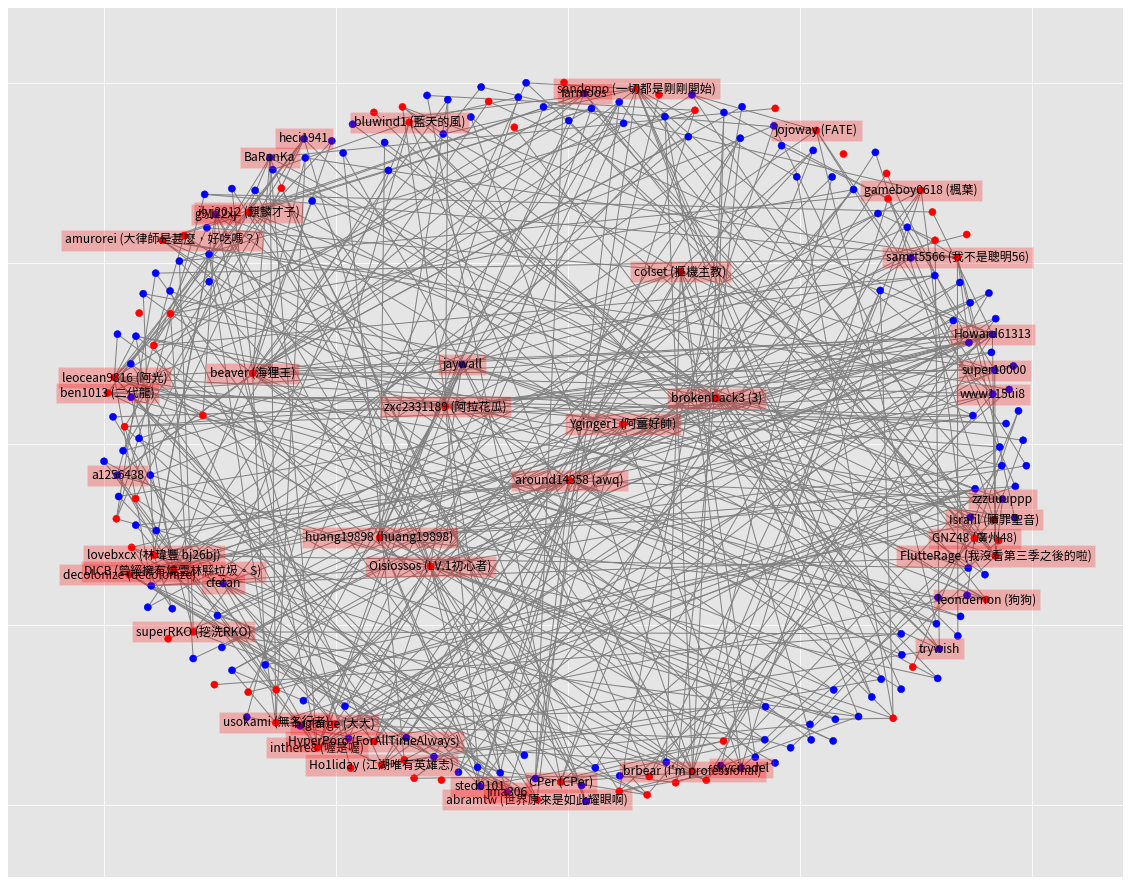

In [93]:
fig, ax = plt.subplots(figsize=(20, 16))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)
#pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels=False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G, pos, labels, font_family='Taipei Sans TC Beta', bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')

plt.show()

In [80]:
# degree centrality
degree = nx.degree_centrality(G)
degree

{'ARCHER2234': 0.009174311926605505,
 'Abre (2)': 0.01834862385321101,
 'Anvec': 0.013761467889908258,
 'Articuno (水噹噹)': 0.013761467889908258,
 'BaRanKa': 0.03669724770642202,
 'Brioni': 0.009174311926605505,
 'Butcherdon': 0.013761467889908258,
 'CNSaya': 0.009174311926605505,
 'CPer (CPer)': 0.03211009174311927,
 'CYL009': 0.01834862385321101,
 'CortexA9': 0.009174311926605505,
 'DICB (曾經擁有燒雲林縣垃圾。S)': 0.027522935779816515,
 'DORAQMON (哆啦哭夢)': 0.0045871559633027525,
 'DarkHolbach': 0.009174311926605505,
 'DarkHolbach (Champagne Supernova)': 0.022935779816513763,
 'Dragula (☂Ⓓⓡⓐⓖⓤⓛⓐ™☂)': 0.022935779816513763,
 'Eden0314': 0.009174311926605505,
 'Eijidate': 0.009174311926605505,
 'Ekmund': 0.009174311926605505,
 'FlutteRage (我沒看第三季之後的啦)': 0.045871559633027525,
 'GNZ48': 0.013761467889908258,
 'GNZ48 (廣州48)': 0.03211009174311927,
 'Gotham (萬惡之城)': 0.0,
 'HKCs': 0.009174311926605505,
 'Hazelburn': 0.009174311926605505,
 'Ho1liday (江湖唯有英雄志)': 0.03669724770642202,
 'Howard61313': 0.0779816

In [81]:
# eigenvector centrality
eigenvector = nx.eigenvector_centrality(G)

In [82]:
# pagerank centrality
pr = nx.pagerank(G, alpha=0.9)

In [83]:
# betweenness centrality
between = nx.betweenness_centrality(G)

In [84]:
# 找出degree centrality最高的前5名
print("degree centrality:", sorted(degree, key=degree.get, reverse=True)[:5])

# 找出eigenvector centrality最高的前5名
print("eigenvector centrality:", sorted(eigenvector, key=eigenvector.get, reverse=True)[:5])

# 找出pagerank centrality最高的前5名
print("pagerank centrality:", sorted(pr, key=pr.get, reverse=True)[:5])

# 找出betweenness centrality最高的前5名
print("betweenness centrality:", sorted(between, key=between.get, reverse=True)[:5])

degree centrality: ['brokenback3 (3)', 'Oisiossos (LV.1初心者)', 'beaver (海狸王)', 'huang19898 (huang19898)', 'leocean9816 (阿光)']
eigenvector centrality: ['Oisiossos (LV.1初心者)', 'Howard61313', 'beaver (海狸王)', 'leocean9816 (阿光)', 'huang19898 (huang19898)']
pagerank centrality: ['brokenback3 (3)', 'Oisiossos (LV.1初心者)', 'beaver (海狸王)', 'huang19898 (huang19898)', 'Howard61313']
betweenness centrality: ['Oisiossos (LV.1初心者)', 'brokenback3 (3)', 'Howard61313', 'beaver (海狸王)', 'huang19898 (huang19898)']


### 主題篩選
無法


In [85]:
# 加上topic
topic_all = pd.merge(link_all, posts_Reviews, on=["push_userid", "article_id"], how="left")[
    ["push_userid", "article_id", "topic"]].drop_duplicates()

In [86]:
# 需要 push_userid 所以merge link，之後使用drop_duplicates去除重複資料
link_all_topic = pd.merge(topic_all, link, on=["push_userid", "article_id"], how="left").drop_duplicates()
link_all_topic.reset_index(inplace=True, drop=True)  #重設index
link_all_topic.shape

(925, 4)

In [96]:
# Create network plot
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge = []
for i in range(0, len(link_all_topic)):
    G.add_edge(link_all_topic["push_userid"][i], link_all_topic["author"][i])
    if link_all_topic["topic"][i] == 0:  #以主題區分顏色
        color_map_edge.append('orange')  # 主題零:報導相關
    else:
        color_map_edge.append('grey')  # 主題二:調侃相關

In [97]:
# 刪除degree<1的點
to_be_removed = [x for x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [98]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
if allPoster[allPoster["user"] == node]["type"].item() == "replayer":
    color_map.append('blue')
else:
    color_map.append('red')

In [99]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val > 5]
degrees
# 把找出的人加進label中
labels = {}
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value
        labels[node] = node

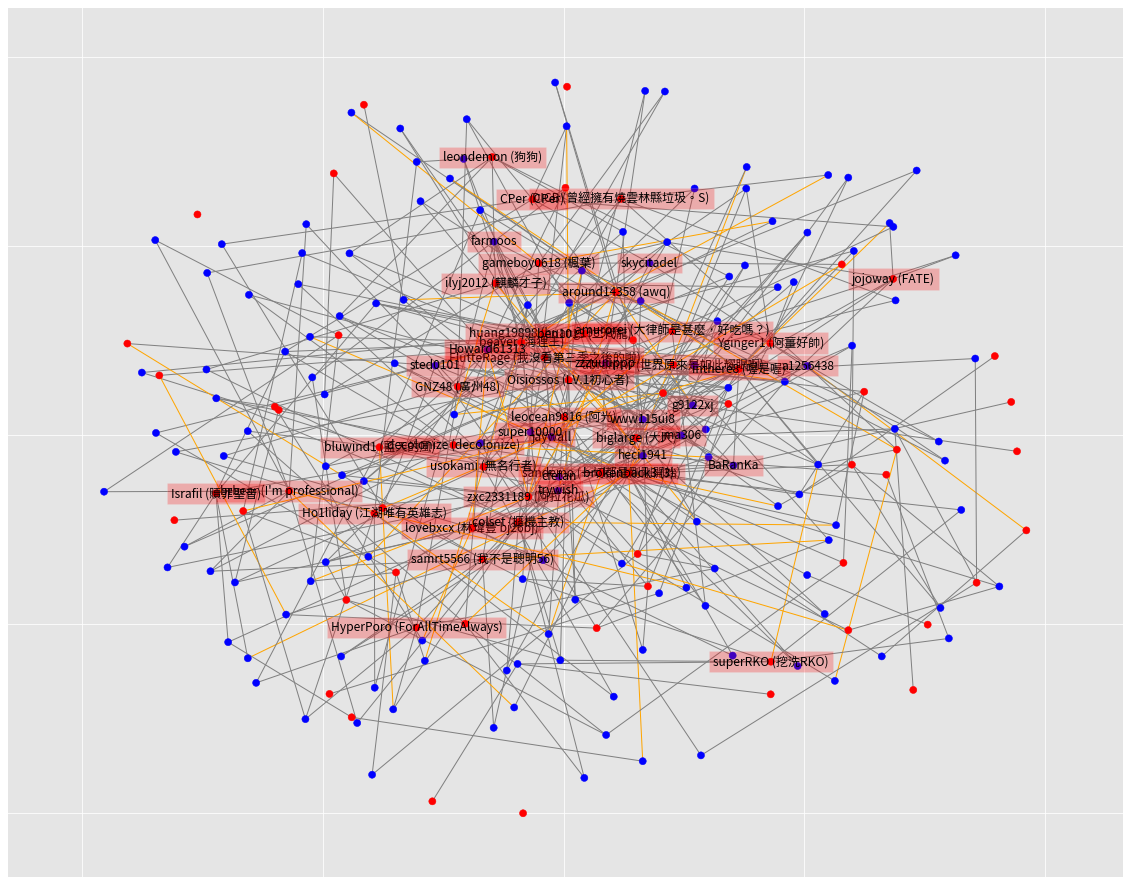

In [100]:
fig, ax = plt.subplots(figsize=(20, 16))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=0.5)
#pos = nx.spectral_layout(G)
# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge,
                 node_color=color_map,
                 with_labels=False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G, pos, labels, font_family='Taipei Sans TC Beta',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')

plt.show()